## CLASSIFIER OF EIGENVECTORS FROM <u>FC</u>

### win_size = 10 stride = 10
By extracting vectors with win_size=10 and stride=10 from the previous notebook, I obtained one eigenvector for each emotion for each subject.  
Therefore, I have only 40 vectors per emotion.  
I test two classification models: Random Forest Classifier and Multilayer Perceptron.

#### loading and preprocessing the dataset

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Loading the data
first_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_static/eigenvectors_calm.npz")["data"]
second_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_static/eigenvectors_afraid.npz")["data"]
third_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_static/eigenvectors_delighted.npz")["data"]
fourth_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_static/eigenvectors_excited.npz")["data"]
fifth_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_static/eigenvectors_depressed.npz")["data"]

# Concatenating the data
X = np.vstack([first_data, second_data, third_data, fourth_data, fifth_data])  # Shape: (200, 90)

# Creating the labels
y = np.array(
    ["calm"] * len(first_data) + ["afraid"] * len(second_data) +
    ["delighted"] * len(third_data) + ["excited"] * len(fourth_data) + ["depressed"] * len(fifth_data)
)  # Shape: (200,)

# Splitting the data: 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)

# Creating the scaler
scaler = StandardScaler()

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalizing only the training data
X_train_scaled = scaler.fit_transform(X_train)

# Applying the same transformation (mean and standard deviation calculated on the training data)
X_test_scaled = scaler.transform(X_test)  # NOTE: We use 'transform' to avoid data leakage

# Checks
print("Train:", X_train_scaled.shape, y_train.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

# Now the training data is normalized, and the test data has been transformed in the same way


Train: (140, 200) (140,)
Test: (60, 200) (60,)


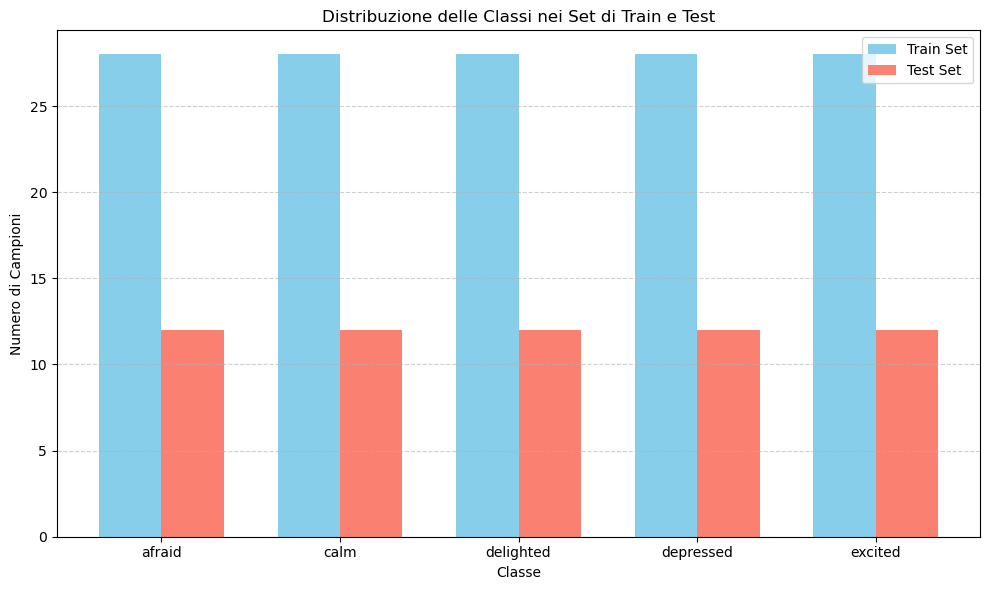

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

# Conta le etichette nei set di training e test
train_counts = Counter(y_train)
test_counts = Counter(y_test)

# Ordine coerente delle classi
classes = sorted(set(y))

# Estrai i valori in ordine
train_values = [train_counts.get(c, 0) for c in classes]
test_values = [test_counts.get(c, 0) for c in classes]

# Larghezza delle barre
bar_width = 0.35
x = np.arange(len(classes))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, train_values, width=bar_width, label='Train Set', color='skyblue')
plt.bar(x + bar_width/2, test_values, width=bar_width, label='Test Set', color='salmon')

# Etichette
plt.xlabel('Classe')
plt.ylabel('Numero di Campioni')
plt.title('Distribuzione delle Classi nei Set di Train e Test')
plt.xticks(ticks=x, labels=classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### random forest classifier

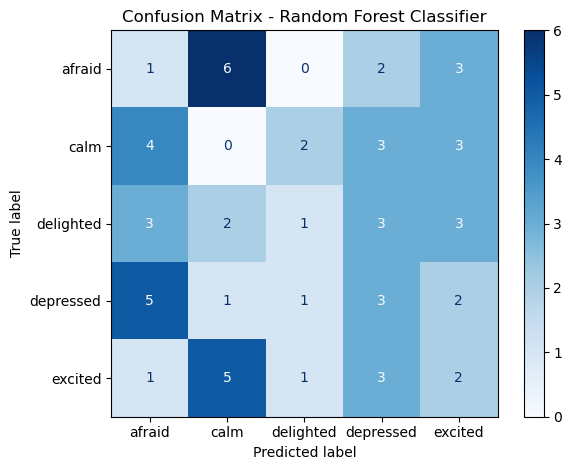

Accuracy: 0.1167


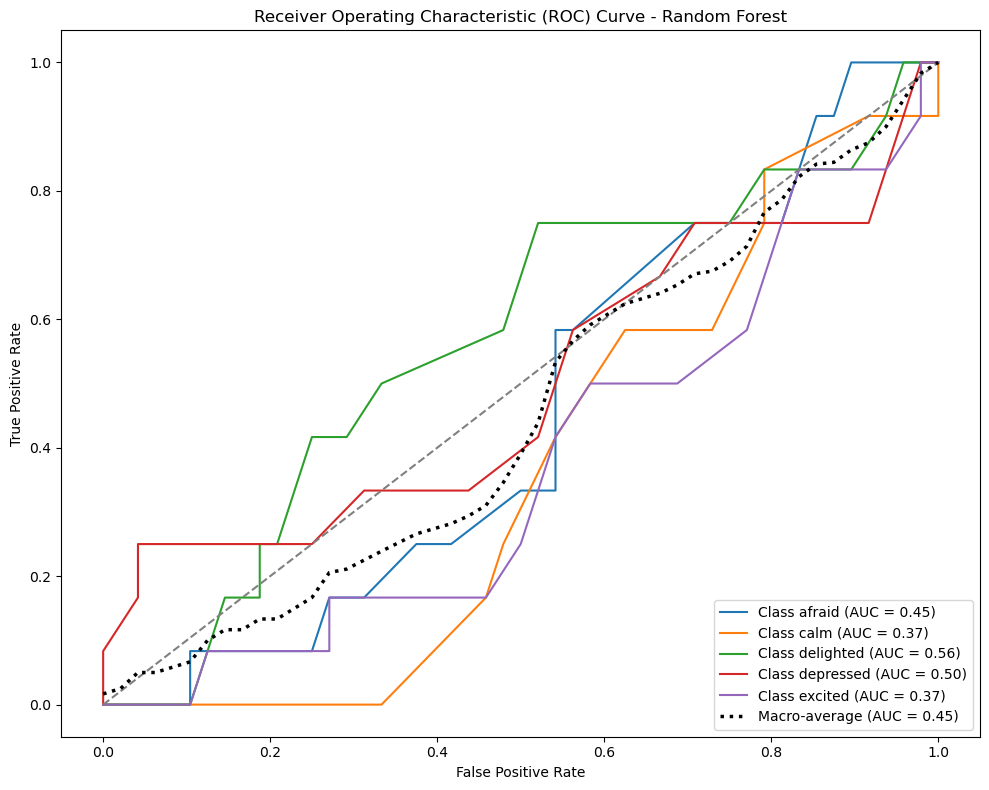

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Creating the Random Forest model
rfc = RandomForestClassifier(random_state=45)

# Training the model with the normalized training data
rfc.fit(X_train_scaled, y_train)  # Use X_train_scaled instead of X_train

# Predictions on the normalized test data
y_pred = rfc.predict(X_test_scaled)  # Use X_test_scaled instead of X_test

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='Blues')

# Adding titles and other information
plt.title("Confusion Matrix - Random Forest Classifier")
plt.tight_layout()
plt.show()

# Printing the accuracy
print(f"Accuracy: {accuracy:.4f}")

# Creating the ROC curve
# Binarized labels for ROC curve calculation
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_prob = rfc.predict_proba(X_test_scaled)

# Calculating the ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y_train))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal (random case)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Calculating the macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting the macro-average ROC before the legend
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
         linestyle=':', linewidth=2.5, color='black')

# Now generate the legend AFTER plotting everything
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### multilayer perceptron

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


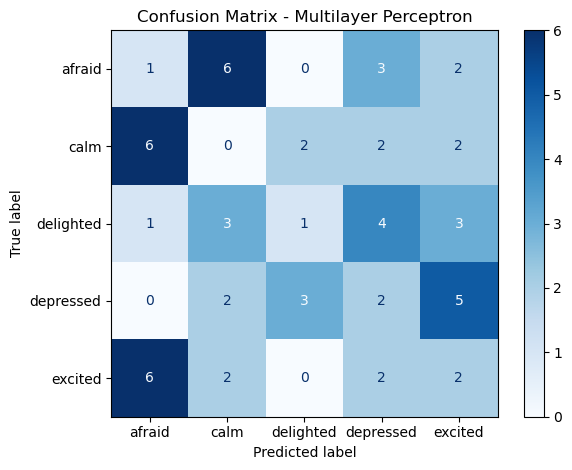

Accuracy: 0.1000


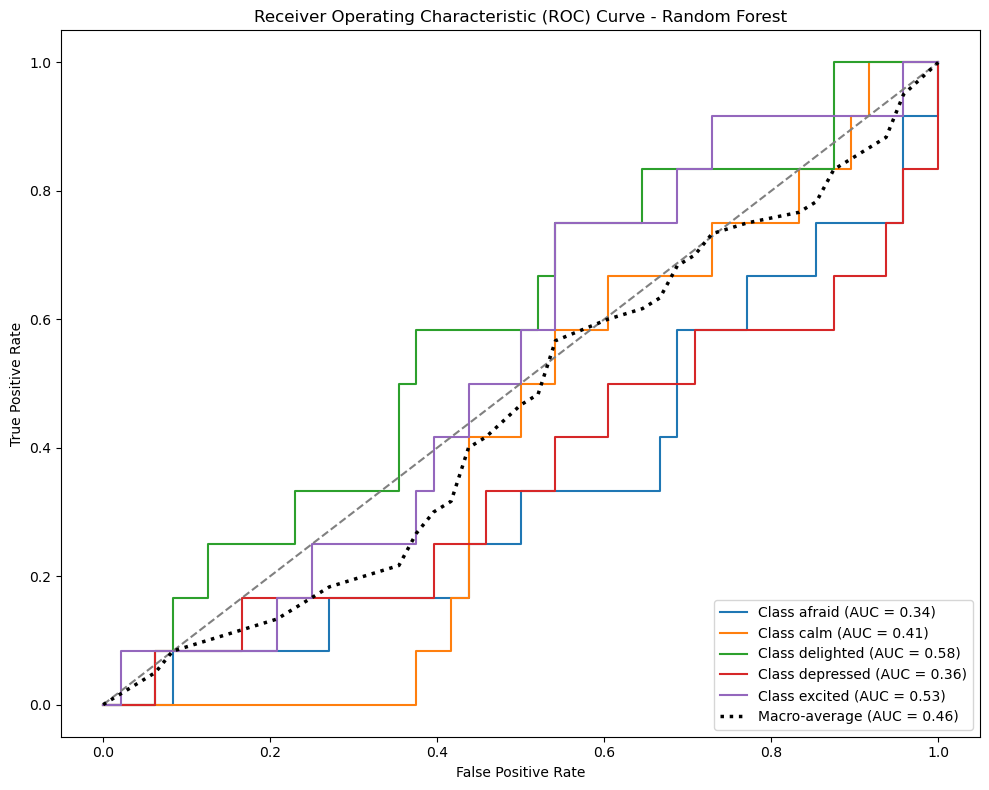

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Creating the Multilayer Perceptron model
#mlp = MLPClassifier(random_state=42, max_iter=1000)

mlp = MLPClassifier(random_state=42)

# Training the model with the normalized training data
mlp.fit(X_train_scaled, y_train)  # Use X_train_scaled instead of X_train

# Predictions on the normalized test data
y_pred = mlp.predict(X_test_scaled)  # Use X_test_scaled instead of X_test

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='Blues')

# Adding titles and other information
plt.title("Confusion Matrix - Multilayer Perceptron")
plt.tight_layout()
plt.show()

# Printing the accuracy
print(f"Accuracy: {accuracy:.4f}")

# Creating the ROC curve
# Binarized labels for ROC curve calculation
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_prob = mlp.predict_proba(X_test_scaled)

# Calculating the ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y_train))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal (random case)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Calculating the macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting the macro-average ROC BEFORE the legend
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
         linestyle=':', linewidth=2.5, color='black')

# Now generate the legend AFTER plotting everything
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## CLASSIFIER OF EIGENVECTORS FROM <u>DFC</u>


### win_size = 4 stride = 2
By extracting vectors with win_size=4 and stride=2, I obtain more eigenvectors for each emotion of each subject.
However, despite having more data, I expect greater similarity among the vectors, which carries the risk that the algorith might "memorize" the training data and fail to generalize properly, leading to poor performance on the test set.

#### loading and preprocessing the dataset

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Loading the data
first_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_4-2/eigenvectors_calm.npz")["data"]
second_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_4-2/eigenvectors_afraid.npz")["data"]
third_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_4-2/eigenvectors_delighted.npz")["data"]
fourth_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_4-2/eigenvectors_excited.npz")["data"]
fifth_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors_4-2/eigenvectors_depressed.npz")["data"]

# Concatenating the data
X = np.vstack([first_data, second_data, third_data, fourth_data, fifth_data])  # Shape: (200, 90)

# Creating the labels
y = np.array(
    ["calm"] * len(first_data) + ["afraid"] * len(second_data) +
    ["delighted"] * len(third_data) + ["excited"] * len(fourth_data) + ["depressed"] * len(fifth_data)
)  # Shape: (200,)

# Splitting the data: 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)

# Creating the scaler
scaler = StandardScaler()

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalizing only the training data
X_train_scaled = scaler.fit_transform(X_train)

# Applying the same transformation (mean and standard deviation calculated on the training data)
X_test_scaled = scaler.transform(X_test)  # NOTE: We use 'transform' to avoid data leakage

# Checks
print("Train:", X_train_scaled.shape, y_train.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

# Now the training data is normalized, and the test data has been transformed in the same way


Train: (1120, 200) (1120,)
Test: (480, 200) (480,)


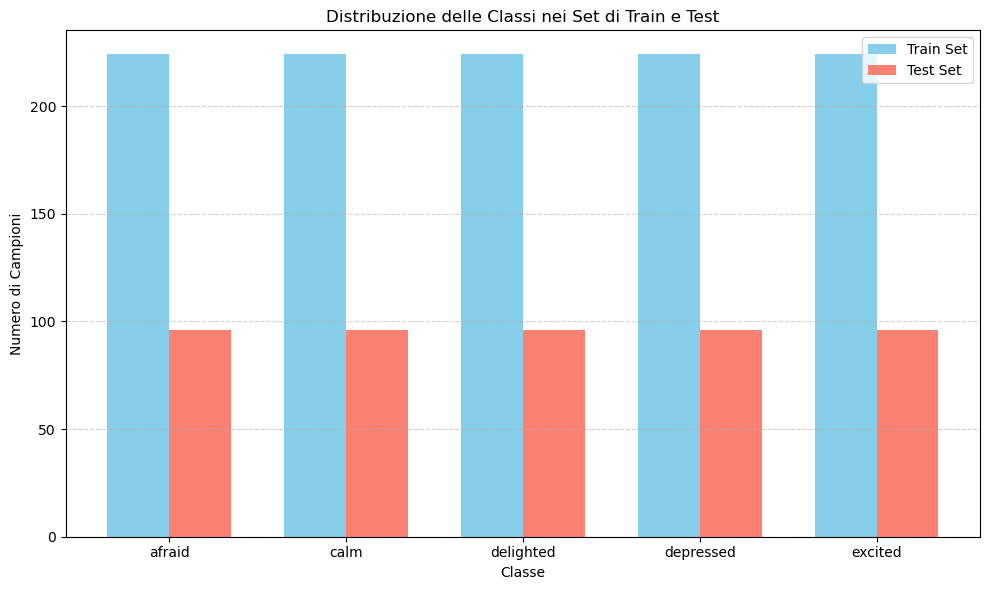

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

# Conta le etichette nei set di training e test
train_counts = Counter(y_train)
test_counts = Counter(y_test)

# Ordine coerente delle classi
classes = sorted(set(y))

# Estrai i valori in ordine
train_values = [train_counts.get(c, 0) for c in classes]
test_values = [test_counts.get(c, 0) for c in classes]

# Larghezza delle barre
bar_width = 0.35
x = np.arange(len(classes))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, train_values, width=bar_width, label='Train Set', color='skyblue')
plt.bar(x + bar_width/2, test_values, width=bar_width, label='Test Set', color='salmon')

# Etichette
plt.xlabel('Classe')
plt.ylabel('Numero di Campioni')
plt.title('Distribuzione delle Classi nei Set di Train e Test')
plt.xticks(ticks=x, labels=classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### random forest classifier

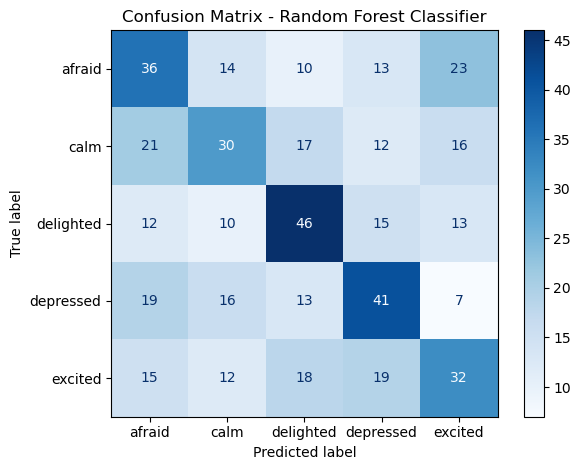

Accuracy: 0.3854


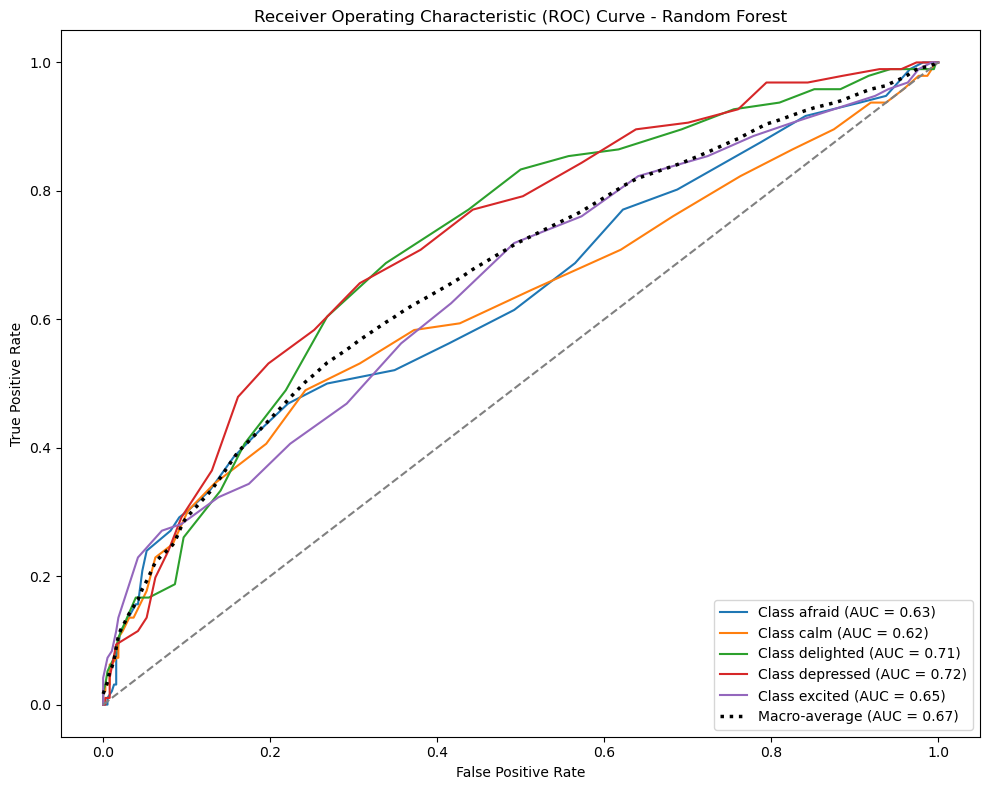

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Creating the Random Forest model
rfc = RandomForestClassifier(random_state=45)

# Training the model with the normalized training data
rfc.fit(X_train_scaled, y_train)  # Use X_train_scaled instead of X_train

# Predictions on the normalized test data
y_pred = rfc.predict(X_test_scaled)  # Use X_test_scaled instead of X_test

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='Blues')

# Adding titles and other information
plt.title("Confusion Matrix - Random Forest Classifier")
plt.tight_layout()
plt.show()

# Printing the accuracy
print(f"Accuracy: {accuracy:.4f}")

# Creating the ROC curve
# Binarized labels for ROC curve calculation
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_prob = rfc.predict_proba(X_test_scaled)

# Calculating the ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y_train))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal (random case)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Calculating the macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting the macro-average ROC before the legend
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
         linestyle=':', linewidth=2.5, color='black')

# Now generate the legend AFTER plotting everything
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### multilayer perceptron

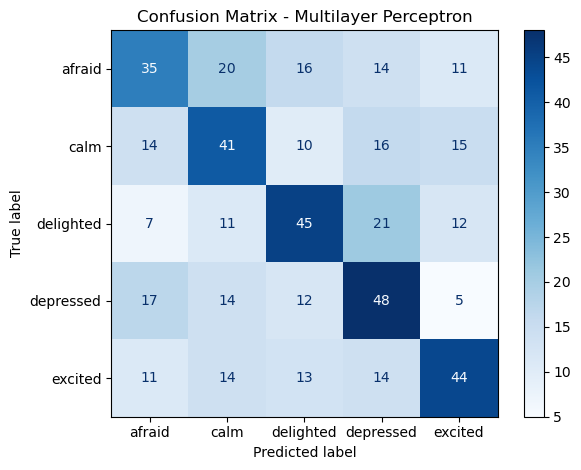

Accuracy: 0.4437


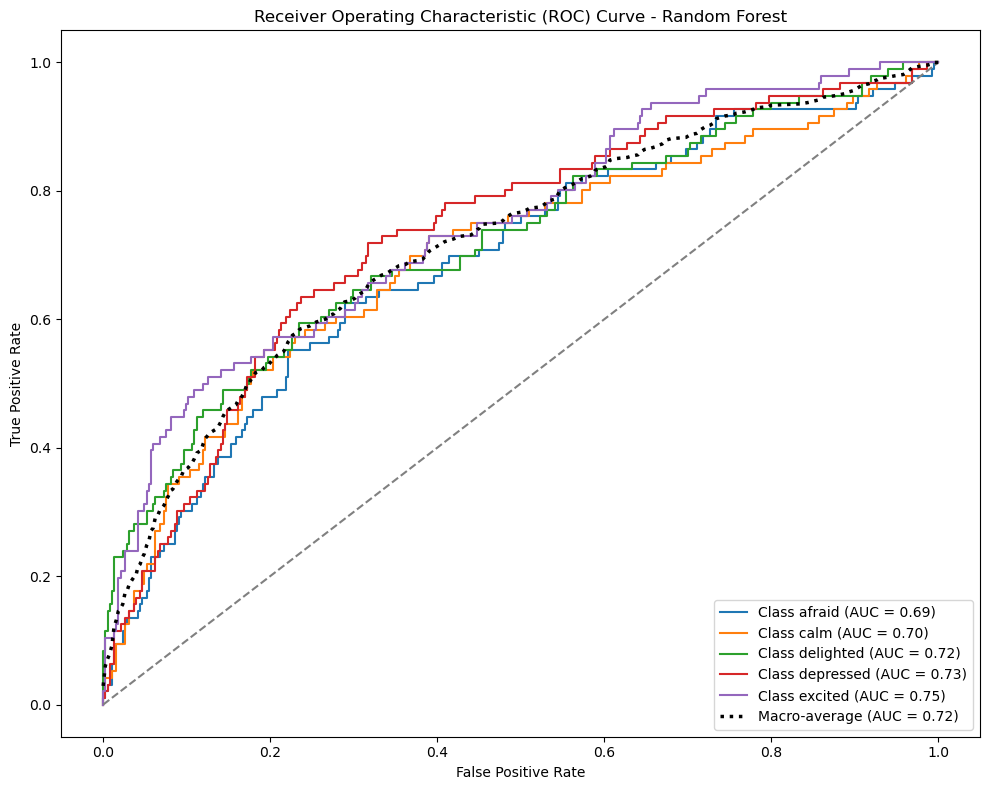

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Creating the Multilayer Perceptron model
#mlp = MLPClassifier(random_state=42, max_iter=1000)

mlp = MLPClassifier(random_state=42)

# Training the model with the normalized training data
mlp.fit(X_train_scaled, y_train)  # Use X_train_scaled instead of X_train

# Predictions on the normalized test data
y_pred = mlp.predict(X_test_scaled)  # Use X_test_scaled instead of X_test

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='Blues')

# Adding titles and other information
plt.title("Confusion Matrix - Multilayer Perceptron")
plt.tight_layout()
plt.show()

# Printing the accuracy
print(f"Accuracy: {accuracy:.4f}")

# Creating the ROC curve
# Binarized labels for ROC curve calculation
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_prob = mlp.predict_proba(X_test_scaled)

# Calculating the ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y_train))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal (random case)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Calculating the macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting the macro-average ROC BEFORE the legend
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
         linestyle=':', linewidth=2.5, color='black')

# Now generate the legend AFTER plotting everything
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



### win_size = 8 stride = 2

For the final attempt, I train the models using the eigenvectors extracted with the previous code, using win_size = 8 and stride = 2. This should be a good compromise to obtain a sufficient amount of data without having vectors that are too similar to each other, allowing the algorith to generalize effectively.

#### loading and preprocessing the dataset

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Loading the data
first_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors/eigenvectors_calm.npz")["data"]
second_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors/eigenvectors_afraid.npz")["data"]
third_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors/eigenvectors_delighted.npz")["data"]
fourth_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors/eigenvectors_excited.npz")["data"]
fifth_data = np.load("/Users/irenesilvestro/cartella_locale/eigenvectors/eigenvectors_depressed.npz")["data"]

# Concatenating the data
X = np.vstack([first_data, second_data, third_data, fourth_data, fifth_data])  # Shape: (200, 90)

# Creating the labels
y = np.array(
    ["calm"] * len(first_data) + ["afraid"] * len(second_data) +
    ["delighted"] * len(third_data) + ["excited"] * len(fourth_data) + ["depressed"] * len(fifth_data)
)  # Shape: (200,)

# Splitting the data: 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)

# Creating the scaler
scaler = StandardScaler()

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalizing only the training data
X_train_scaled = scaler.fit_transform(X_train)

# Applying the same transformation (mean and standard deviation calculated on the training data)
X_test_scaled = scaler.transform(X_test)  # NOTE: We use 'transform' to avoid data leakage

# Checks
print("Train:", X_train_scaled.shape, y_train.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

# Now the training data is normalized, and the test data has been transformed in the same way


Train: (840, 200) (840,)
Test: (360, 200) (360,)


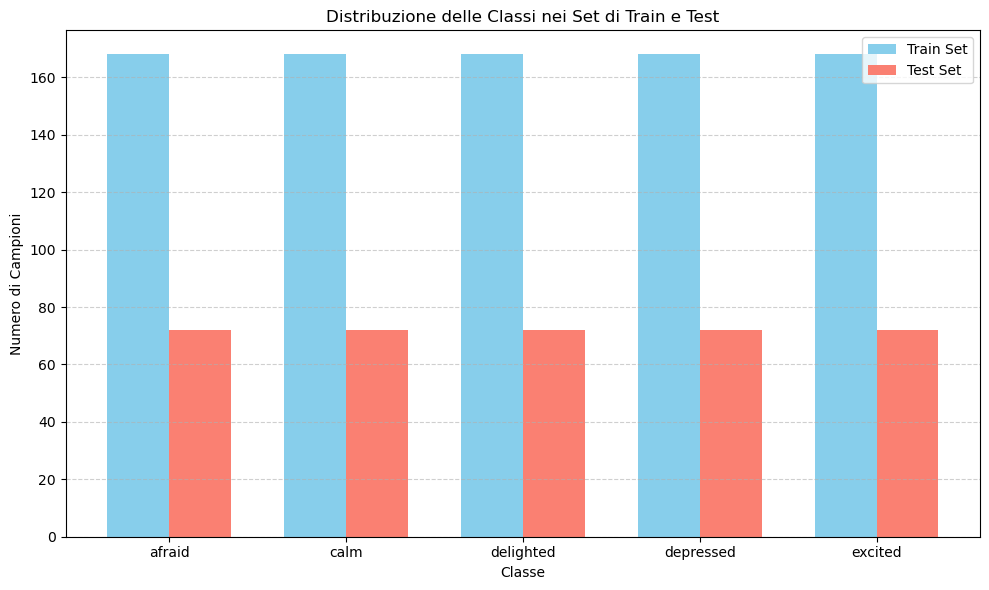

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Conta le etichette nei set di training e test
train_counts = Counter(y_train)
test_counts = Counter(y_test)

# Ordine coerente delle classi
classes = sorted(set(y))

# Estrai i valori in ordine
train_values = [train_counts.get(c, 0) for c in classes]
test_values = [test_counts.get(c, 0) for c in classes]

# Larghezza delle barre
bar_width = 0.35
x = np.arange(len(classes))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, train_values, width=bar_width, label='Train Set', color='skyblue')
plt.bar(x + bar_width/2, test_values, width=bar_width, label='Test Set', color='salmon')

# Etichette
plt.xlabel('Classe')
plt.ylabel('Numero di Campioni')
plt.title('Distribuzione delle Classi nei Set di Train e Test')
plt.xticks(ticks=x, labels=classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### random forest classifier

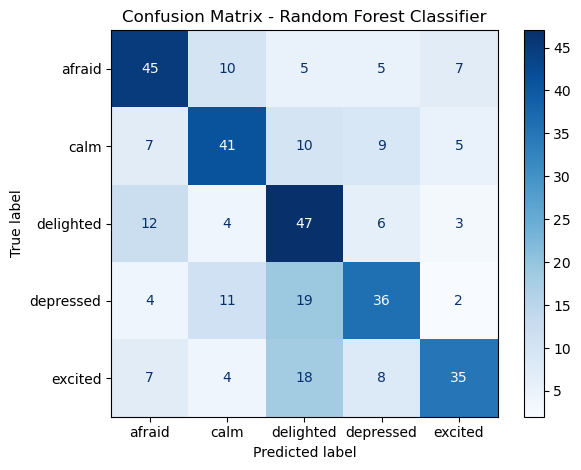

Accuracy: 0.5667


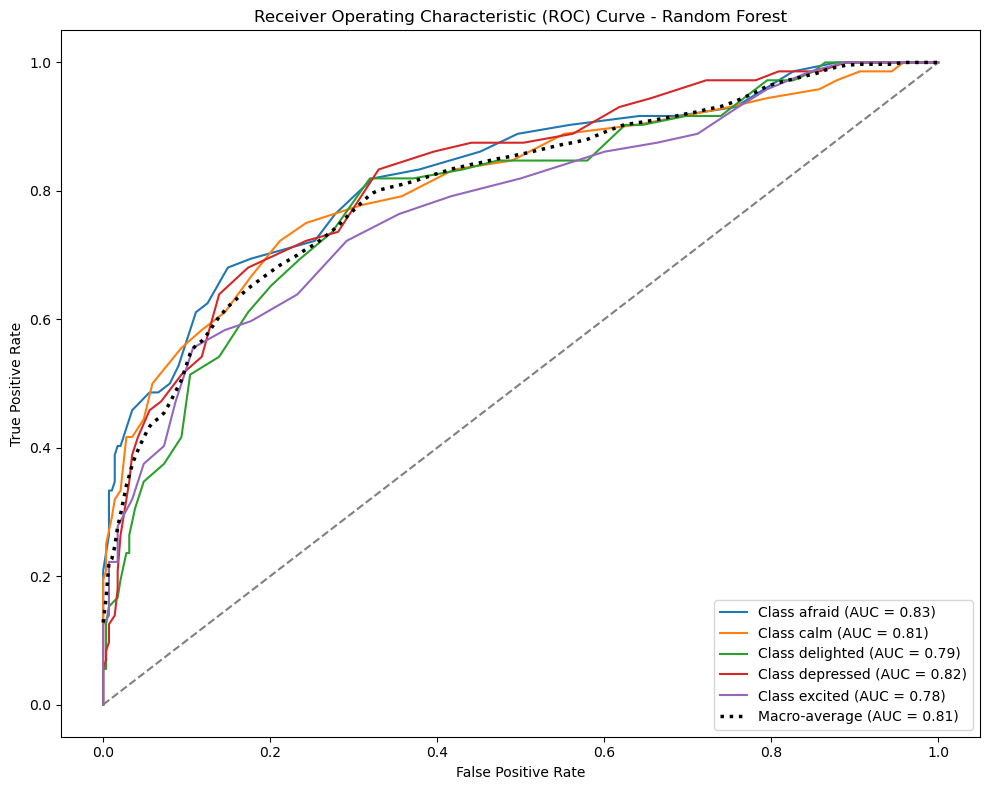

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Creating the Random Forest model
rfc = RandomForestClassifier(random_state=45)
#rfc = RandomForestClassifier()

# Training the model with the normalized training data
rfc.fit(X_train_scaled, y_train)  # Use X_train_scaled instead of X_train

# Predictions on the normalized test data
y_pred = rfc.predict(X_test_scaled)  # Use X_test_scaled instead of X_test

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='Blues')

# Adding titles and other information
plt.title("Confusion Matrix - Random Forest Classifier")
plt.tight_layout()
plt.show()

# Printing the accuracy
print(f"Accuracy: {accuracy:.4f}")

# Creating the ROC curve
# Binarized labels for the ROC curve calculation
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_prob = rfc.predict_proba(X_test_scaled)

# Calculating the ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y_train))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal (random case)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Calculating the macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting the macro-average ROC BEFORE the legend
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
         linestyle=':', linewidth=2.5, color='black')

# Now generate the legend AFTER plotting everything
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### multilayer perceptron

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


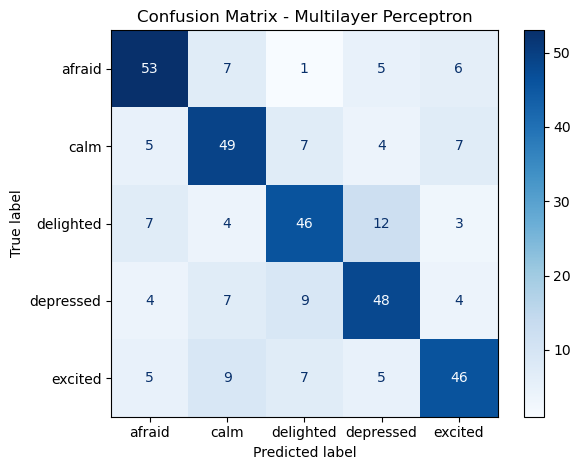

Accuracy: 0.6722


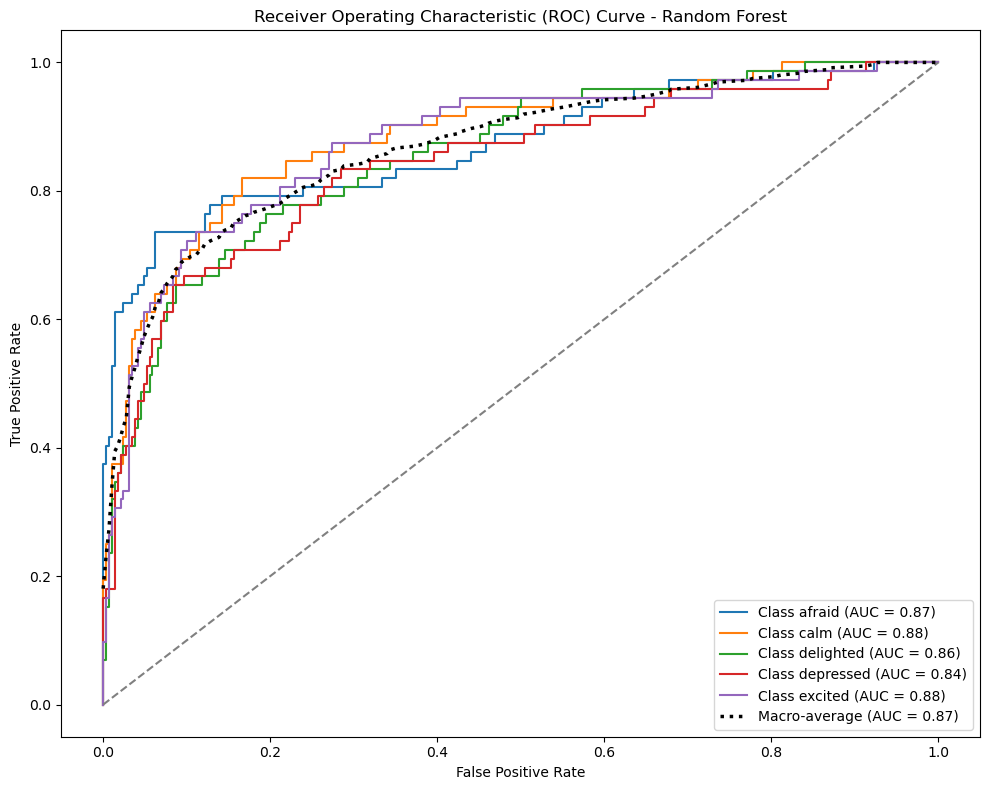

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Creating the Multilayer Perceptron model
#mlp = MLPClassifier(random_state=42, max_iter=1000)

mlp = MLPClassifier(random_state=42)

# Training the model with the normalized training data
mlp.fit(X_train_scaled, y_train)  # Use X_train_scaled instead of X_train

# Predictions on the normalized test data
y_pred = mlp.predict(X_test_scaled)  # Use X_test_scaled instead of X_test

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='Blues')

# Adding titles and other information
plt.title("Confusion Matrix - Multilayer Perceptron")
plt.tight_layout()
plt.show()

# Printing the accuracy
print(f"Accuracy: {accuracy:.4f}")

# Creating the ROC curve
# Binarized labels for the ROC curve calculation
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_prob = mlp.predict_proba(X_test_scaled)

# Calculating the ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y_train))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal (random case)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Calculating the macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting the macro-average ROC BEFORE the legend
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
         linestyle=':', linewidth=2.5, color='black')

# Now generate the legend AFTER plotting everything
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
